#  Time series analysis - Example code 25: Example of dual-input transfer function.

**Lund University, Lund, Sweden**


**Reference:** "An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson, Studentlitteratur, 2021

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sys
import os
import importlib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'TimeSeriesAnalysis-main', 'TimeSeriesAnalysis-main')))

from tsa_lth.analysis import acf, pacf
from tsa_lth.tests import whiteness_test, check_if_normal
from tsa_lth.modelling import estimateARMA, polydiv, MultiInputPEM

np.random.seed(0)
extraN = 400
N = 1300
pstart = 1000
noLags = 40

# Generate the noise and the input signals.

In [2]:
# Noise process.
C1 = np.array([1, 0, 0, 0.6])
A1 = np.concatenate([[1], np.zeros(7), [-0.8]])

# First input process, x1.
C3_1 = np.array([1, -0.4, 0.9])
A3_1 = np.concatenate([[1], np.zeros(23), [-0.98]])
B_1 = np.array([4])
A2_1 = np.array([1])

# Second input process, x2.
C3_2 = np.array([1, 0, 0, 0.8])
A3_2 = np.convolve([1, -1], [1, -0.6])
B_2 = np.array([0, 0, 0.8, 0, -1])
A2_2 = np.array([1])

# Generate the noise and the input signals.
z = signal.lfilter(C1, A1, np.random.randn(N + extraN))
x1 = signal.lfilter(C3_1, A3_1, np.random.randn(N + extraN))
x2 = signal.lfilter(C3_2, A3_2, np.random.randn(N + extraN))

# Form the output using the filtered input. Remove the initial samples.
y = signal.lfilter(B_1, A2_1, x1) + signal.lfilter(B_2, A2_2, x2) + z
y = y[extraN:]
x1 = x1[extraN:]
x2 = x2[extraN:]

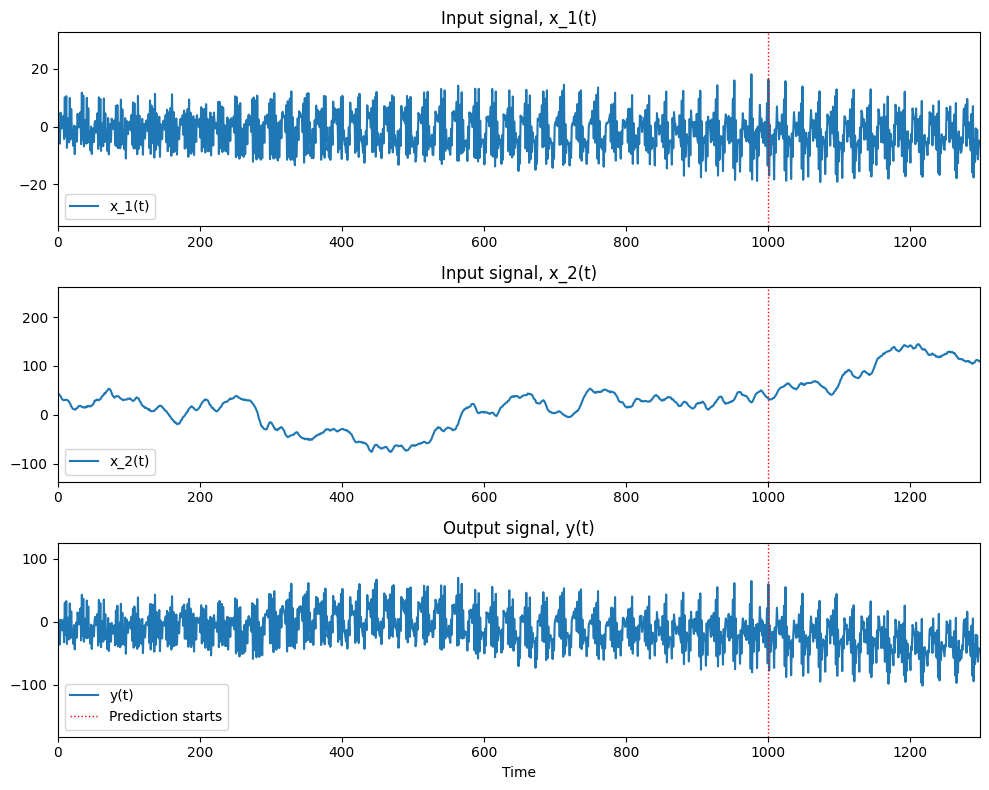

In [3]:
# Plot the processes.
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

axes[0].plot(x1)
axes[0].axvline(x=pstart, color='red', linestyle=':', linewidth=1)
axes[0].set_xlim([0, N-1])
axes[0].set_ylim([np.min(x1)*1.8, np.max(x1)*1.8])
axes[0].set_title('Input signal, x_1(t)')
axes[0].legend(['x_1(t)'], loc='lower left')

axes[1].plot(x2)
axes[1].axvline(x=pstart, color='red', linestyle=':', linewidth=1)
axes[1].set_xlim([0, N-1])
axes[1].set_ylim([np.min(x2)*1.8, np.max(x2)*1.8])
axes[1].set_title('Input signal, x_2(t)')
axes[1].legend(['x_2(t)'], loc='lower left')

axes[2].plot(y)
axes[2].axvline(x=pstart, color='red', linestyle=':', linewidth=1)
axes[2].set_xlim([0, N-1])
axes[2].set_ylim([np.min(y)*1.8, np.max(y)*1.8])
axes[2].set_title('Output signal, y(t)')
axes[2].set_xlabel('Time')
axes[2].legend(['y(t)', 'Prediction starts'], loc='lower left')

plt.tight_layout()
plt.show()

# Create the dual-input for the output data.

See the code modeling.py for further details. Recall that the initial values might be modified (as here).

In [4]:
# Create the dual-input model structure and estimate parameters.
# In MATLAB: polyContainer = idpoly( 1, B, C1_0, A1_0, A2 );
#            dataContainer = iddata( y(1:pstart), [x1(1:pstart) x2(1:pstart)] );
#            foundModel = pem( dataContainer, polyContainer );

B = [[1.0], [0.0, 0.0, 1.0, 0.0, 0.3]]
A2 = [[1.0], [1.0]]
A1_0 = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3]
C1_0 = [1.0, 0.0, 0.0, 0.3]

x_multi = np.column_stack([x1[:pstart], x2[:pstart]])

model = MultiInputPEM(y=y[:pstart], x=x_multi, A=1, B=B, F=A2, C=C1_0, D=A1_0, nk=[0, 0])
model.set_free_params(
    B_free=[[True], [False, False, True, False, True]],
    F_free=None,
    C_free=[False, False, False, True],
    D_free=[False, False, False, False, False, False, False, False, True]
)

foundModel = model.fit(method='LS', verbose=0)
foundModel.summary()

Multi-Input PEM Model Estimation Results

Model: A(z)∇y(t) = sum_i[B_i(z)/F_i(z)]x_i(t) + [C(z)/D(z)]e(t)

Number of inputs: 2

Input 1:
  B[0] = 3.9953(±0.0036)
  F[0] = 1.0

Input 2:
  B[1] = 0.7823(±0.0093)·z⁻² - 0.9814(±0.0093)·z⁻⁴
  F[1] = 1.0

Noise model:
  C = 1.0 + 0.1722(±0.0185)·z⁻³
  D = 1.0 - 0.7888(±0.0188)·z⁻⁸

Fit metrics:
  MSE            :     1.2061
  RMSE           :     1.0982
  NRMSE          :     3.8498
  R2             :     0.9985
  AIC            :  2999.0066
  BIC            :  3023.4850
  FPE            :     1.2174
  LogLikelihood  : -1494.0968
  FitPercent     :    96.1502


Estimate the models of the input signals.

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.9881(±0.0066)·z⁻²⁴
C(z) = 1.0 - 0.3694(±0.0195)·z⁻¹ + 0.7793(±0.0194)·z⁻²

Polynomial orders: nA = 24    nC = 2
Number of free coefficients: 3
Fit to estimation data (NRMSE): 85.45%
FPE : 0.994  MSE : 0.992
AIC : 2767.835   BIC : 2782.486



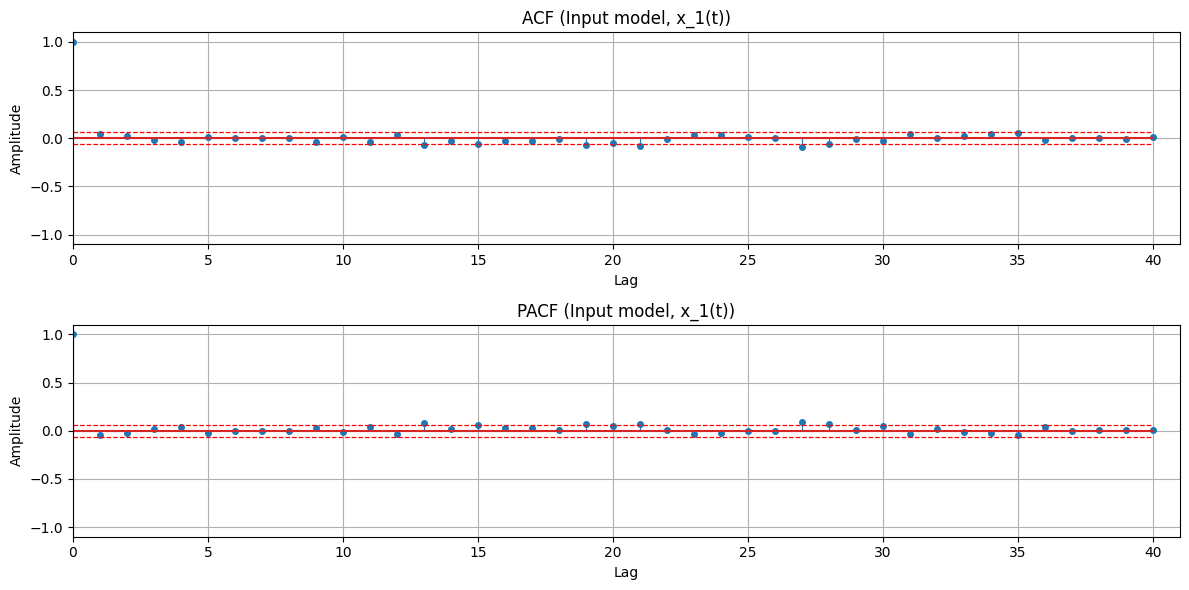

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 34.20 < 37.65)
  McLeod-Li test:        False (white if 71.98 < 37.65)
  Monti test:            True (white if 34.68 < 37.65)
  Sign change test:      True (white if 0.49 in [0.47,0.53])


In [5]:
inputModel1 = estimateARMA(x1[:pstart], np.concatenate([[1], np.zeros(23), [1]]), 
                           np.array([1, 1, 1]), titleStr='Input model, x_1(t)', noLags=noLags)

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.603(±0.0255)·z⁻¹
C(z) = 1.0 + 0.8054(±0.019)·z⁻³

Polynomial orders: nA = 1    nC = 3
Number of free coefficients: 2
Fit to estimation data (NRMSE): 42.7%
FPE : 1.016  MSE : 1.012
AIC : 2847.75   BIC : 2857.562



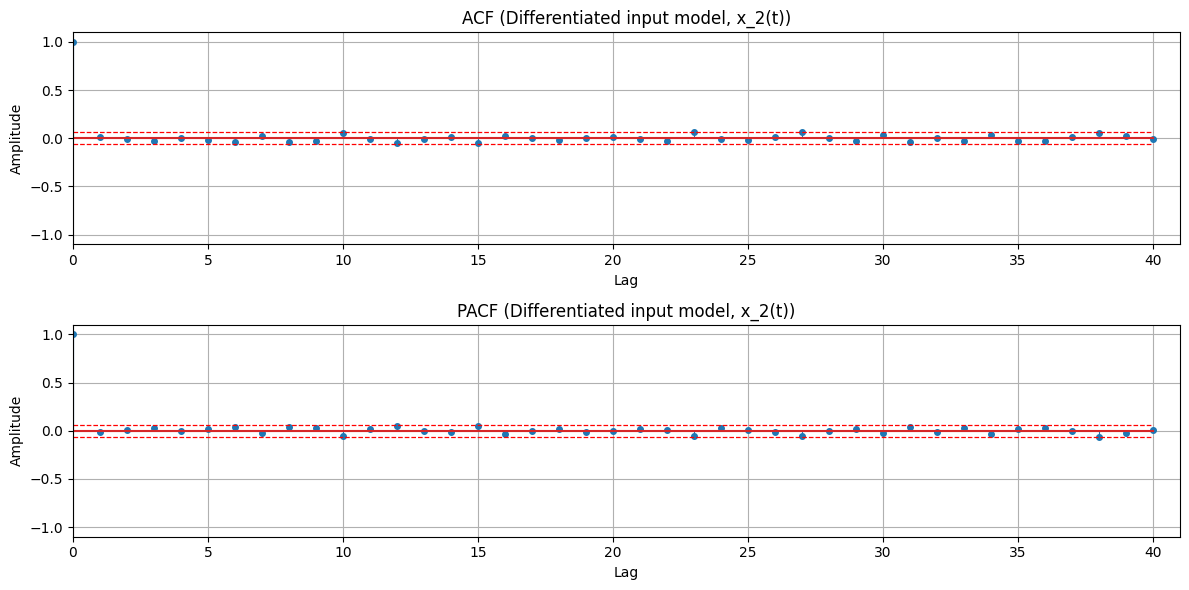

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 20.48 < 37.65)
  McLeod-Li test:        True (white if 22.86 < 37.65)
  Monti test:            True (white if 21.52 < 37.65)
  Sign change test:      True (white if 0.49 in [0.47,0.53])


In [6]:
# To handle the slowly decaying ACF, the data is first differentiated,
# after which the differentiation is again added to the model.
x2_diff = signal.lfilter([1, -1], 1, x2[:pstart])
x2_diff = x2_diff[1:]

inputModel2 = estimateARMA(x2_diff, np.array([1, 1]), np.array([1, 0, 0, 1]), 
                           titleStr='Differentiated input model, x_2(t)', noLags=noLags)
inputModel2.A = np.convolve([1, -1], inputModel2.A)

How do you predict a dual-input BJ?

We need to form the polynomials:<br>
KA = A_1 A_2^1 A_2^2<br>
KB = B^1 A_1 A_2^2<br>
KC = C_1 A_2^1 A_2^2<br>
KD = B^2 A_1 A_2^1

In [7]:
k = 3

# We need to form the polynomials:
#
# KA = A_1 A_2^1 A_2^2
# KB = B^1 A_1 A_2^2
# KC = C_1 A_2^1 A_2^2
# KD = B^2 A_1 A_2^1
#
# In Matlab's notation:
#   A(z) y(t) = [B(z)/F(z)] u(t) + [C(z)/D(z)] e(t)
#
# Here, u(t) is two-dimensional. This means that:
#   A(z) = 1,       B(z) = B(z),    F(z) = A2(z)
#   C(z) = C1(z),   D(z) = A1(z)
#
KA = np.convolve(np.convolve(foundModel.D, foundModel.F[0]), foundModel.F[1])
KB = np.convolve(np.convolve(foundModel.D, foundModel.B[0]), foundModel.F[1])
KC = np.convolve(np.convolve(foundModel.F[0], foundModel.F[1]), foundModel.C)
KD = np.convolve(np.convolve(foundModel.D, foundModel.B[1]), foundModel.F[0])

# Form the polynomial divisions. Note that KC/KA is the same as C1/A1. The
# two latter polynomials will also contain shared components that will
# cancel. Can you see what the resulting divisions are?
Fy, Gy = polydiv(foundModel.C, foundModel.D, k)
Fh1, Gh1 = polydiv(np.convolve(Fy, KB), KC, k)
Fh2, Gh2 = polydiv(np.convolve(Fy, KD), KC, k)

In [8]:
# Predict the input signals.
Fx1, Gx1 = polydiv(inputModel1.C, inputModel1.A, k)
xhatk1 = signal.lfilter(Gx1, inputModel1.C, x1)

Fx2, Gx2 = polydiv(inputModel2.C, inputModel2.A, k)
xhatk2 = signal.lfilter(Gx2, inputModel2.C, x2)

In [9]:
# Form the predicted output signal using the predicted input signals.
yhatk = (signal.lfilter(Fh1, 1, xhatk1) + signal.lfilter(Gh1, KC, x1) +
         signal.lfilter(Fh2, 1, xhatk2) + signal.lfilter(Gh2, KC, x2) +
         signal.lfilter(Gy, KC, y))

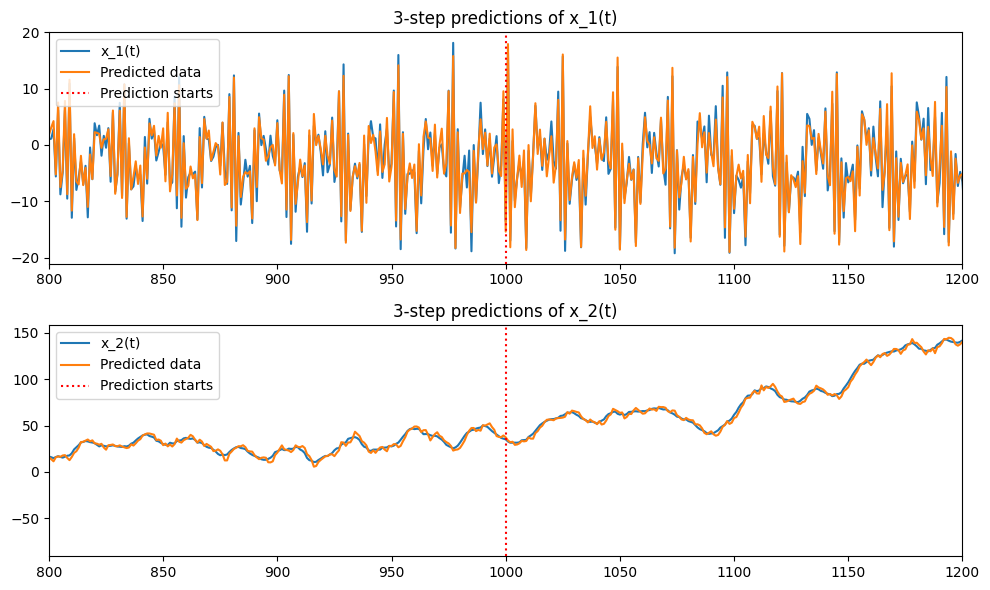

In [10]:
# Plot the resulting predictions
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(x1, label='x_1(t)')
axes[0].plot(xhatk1, label='Predicted data')
axes[0].axvline(x=pstart, color='red', linestyle=':', label='Prediction starts')
axes[0].set_xlim([800, N-100])
axes[0].set_title(f'{k}-step predictions of x_1(t)')
axes[0].legend(loc='upper left')

axes[1].plot(x2, label='x_2(t)')
axes[1].plot(xhatk2, label='Predicted data')
axes[1].axvline(x=pstart, color='red', linestyle=':', label='Prediction starts')
axes[1].set_xlim([800, N-100])
axes[1].set_title(f'{k}-step predictions of x_2(t)')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

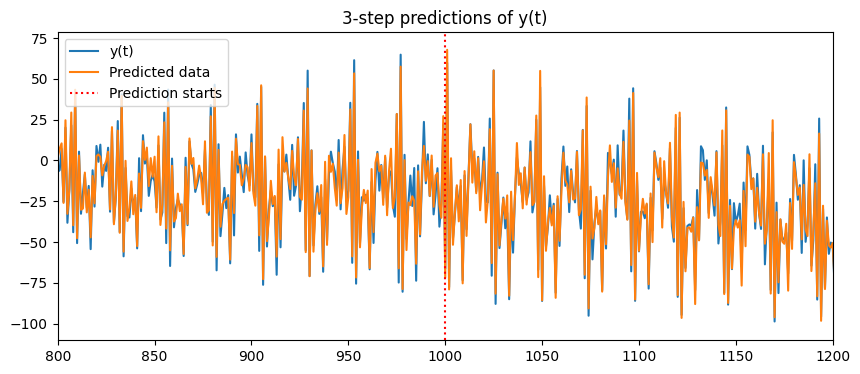

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(y, label='y(t)')
plt.plot(yhatk, label='Predicted data')
plt.axvline(x=pstart, color='red', linestyle=':', label='Prediction starts')
plt.xlim([800, N-100])
plt.title(f'{k}-step predictions of y(t)')
plt.legend(loc='upper left')
plt.show()

# Check the resulting residuals.

In [12]:
ehat = y - yhatk
ehat = ehat[pstart:]

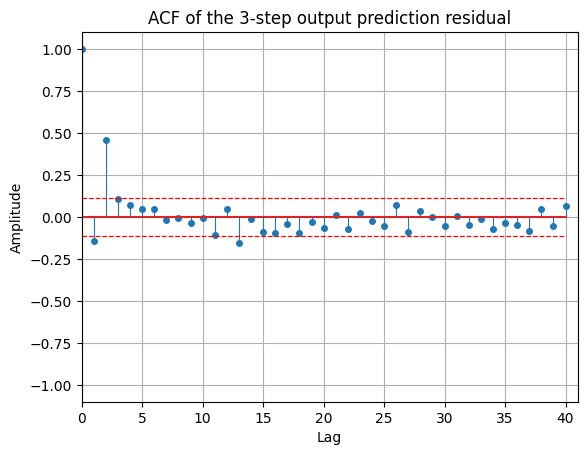

Checking the 3-step output prediction residual.
Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 103.40 < 37.65)
  McLeod-Li test:        True (white if 25.15 < 37.65)
  Monti test:            False (white if 116.84 < 37.65)
  Sign change test:      False (white if 0.56 in [0.44,0.56])


In [13]:
acfEst = acf(ehat, noLags, signLvl=0.05, plotIt=True)
plt.title(f'ACF of the {k}-step output prediction residual')
plt.show()

print(f'Checking the {k}-step output prediction residual.')
whiteness_test(ehat)

In [14]:
pacfEst = pacf(ehat, noLags, signLvl=0.05)
check_if_normal(pacfEst[k+1:], 'PACF')

The Jarque-Bera test indicates that the data is NORMAL distributed!
